In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [3]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

In [4]:
# test_df = pd.read_csv('/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv', index_col=0)
test_df = pd.read_csv('/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv', index_col=0)

In [5]:
filt = test_df[(test_df.encoder == 'PLIP') & (test_df.metric == 'precision') & (test_df.regime == 'class-1')].sort_values('value', ascending=False)
filt.head(20)

,encoder,model,threshold,datum_id,regime,metric,value,method
2395,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_113,class-1,precision,1.000000,K2
1683,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_021,class-1,precision,1.000000,K2
1447,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_073,class-1,precision,1.000000,K2
1387,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_026,class-1,precision,1.000000,K2
2107,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_105,class-1,precision,1.000000,K2
1119,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_075,class-1,precision,1.000000,K2
1075,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_122,class-1,precision,1.000000,K2
1047,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_082,class-1,precision,1.000000,K2
2135,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_121,class-1,precision,1.000000,K2
1759,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_090,class-1,precision,1.000000,K2


<Axes: >

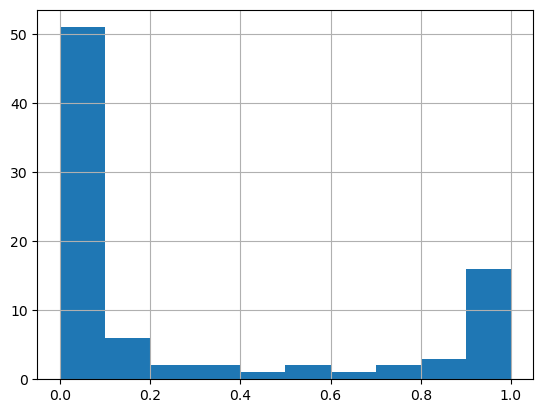

In [6]:
filt.value.hist()

In [7]:
high_precision = filt[filt.value > 0.5]

In [8]:
encoder = 'plip'

# meta_path = "/home/k2/K2/src/outputs/plip_gridsearch/"
meta_path = "/dfs/scratch1/gmachi/gcp_backup/k2/plip_gridsearch/"
processor_cache_dir = meta_path + encoder + "-fitted_k2_processors"
model_cache_dir = meta_path + encoder + "-fitted_k2_models"

# G_test_dir = "/home/data/tinycam/test/clean_Gs_plip"
# G_train_dir = "/home/data/tinycam/train/clean_Gs_plip"
G_test_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_plip"
G_train_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/train/clean_Gs_plip"

model_str = "k15_r1_alpha0.010_tau2.00_lamnan.model" #using the best r>0 model for viz
thresh = 0.5
k,r,alpha,tau,lam = extract_params(model_str)

In [9]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", gt_path=None):
    if datatype == "protein":
        k,r,cutoff,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
        G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)
    elif datatype == "image":
        k,r,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d.processor" % (k)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    if datatype == "protein":
        G_path = G_dir + "/" + G_id + ".pkl"
    elif datatype == "image":
        G_path = G_dir + "/" + G_id 
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    kernel_map = model.visualize_motif_graph(G)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype=="image":
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map)
        prospect_map = model.visualize_prospect_map(P)
        gt = utils.deserialize(os.path.join(gt_path, G_id + "-graph"))
        gt_arr = utils.convert_GTgraph2arr(gt)
        utils.visualize_GTmap(gt_arr, sprite_map)

    return kernel_map, sprite_viz, prospect_map, gt

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


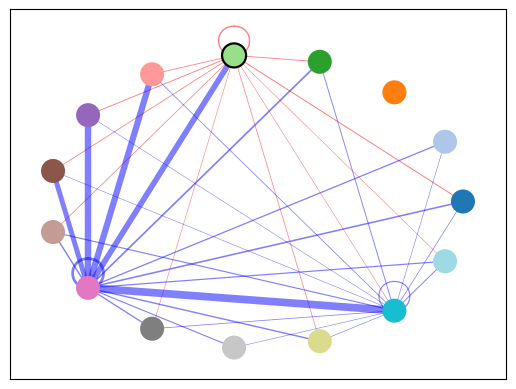

In [10]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph()

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


visualizing motif graph...
Displaying motif graph with log10 scaling


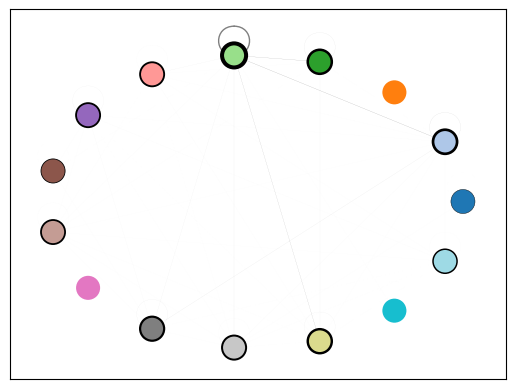

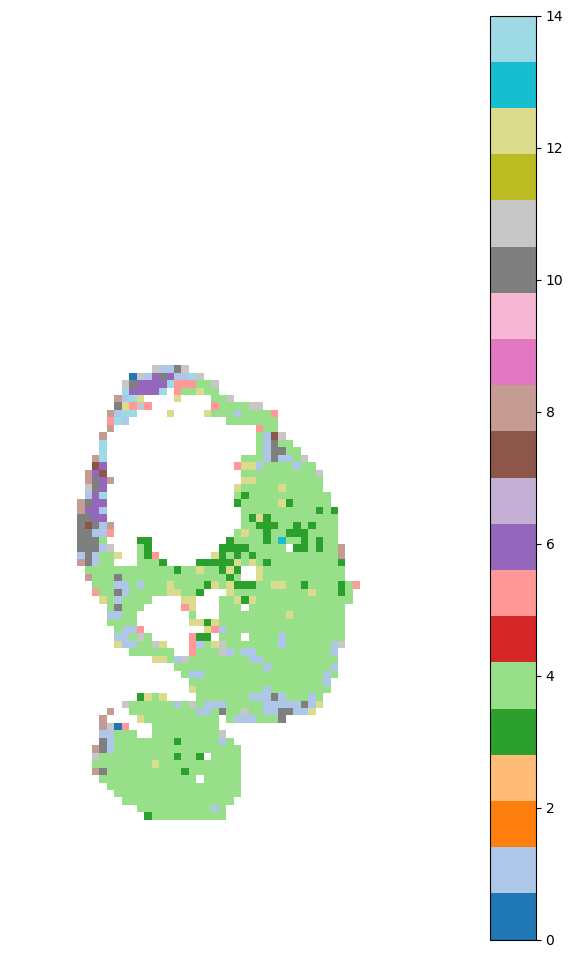

49.94195180642039


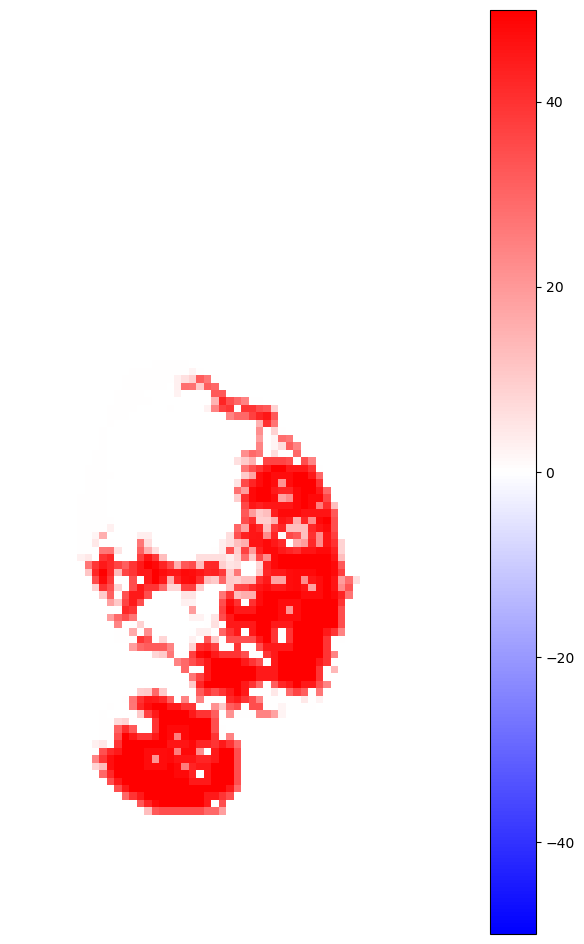

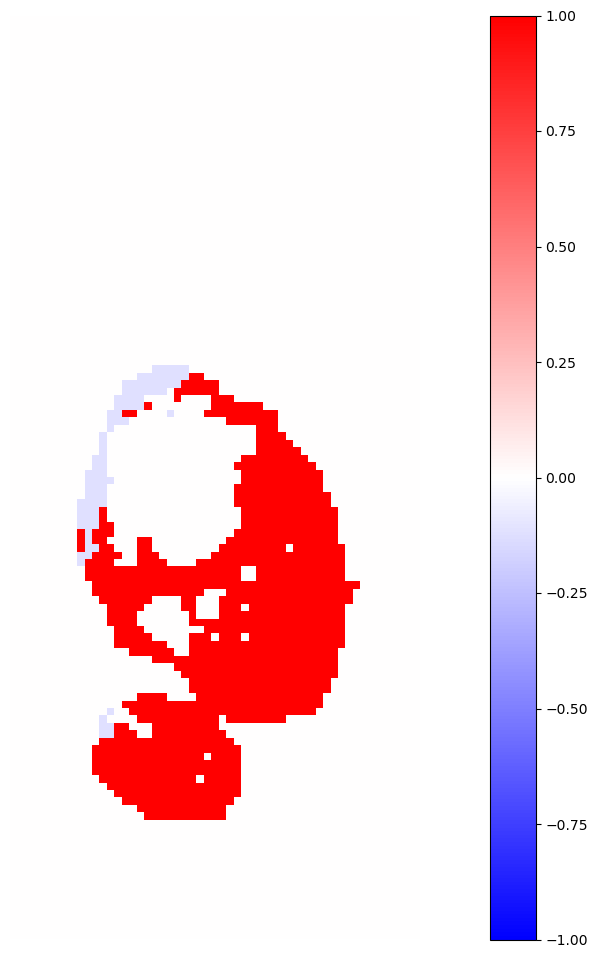

In [12]:
G_id = "G-test_021" 
# gt_path = "/home/data/tinycam/test/gt_graphs_plip"
gt_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_plip"

kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_test_dir, datatype="image", gt_path=gt_path)